# Gradient Boosting

Le notebook explore l'algorithme du [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Premier exemple

On considère les paramètres par défaut de la classe [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor).

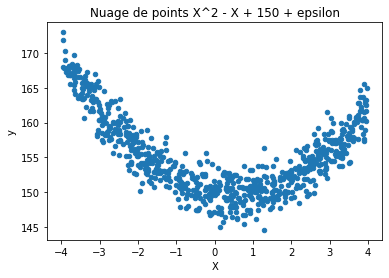

In [3]:
from numpy.random import randn, random
from pandas import DataFrame
from sklearn.model_selection import train_test_split
rnd = randn(1000)
X = random(1000) * 8 - 4
y = X ** 2 - X + rnd * 2 + 150 # X^2 - X + 150 + epsilon
X = X.reshape((-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y)
df = DataFrame({'X': X_train.ravel(), 'y': y_train})
ax = df.plot(x='X', y='y', kind='scatter')
ax.set_title("Nuage de points X^2 - X + 150 + epsilon");

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(max_depth=1)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

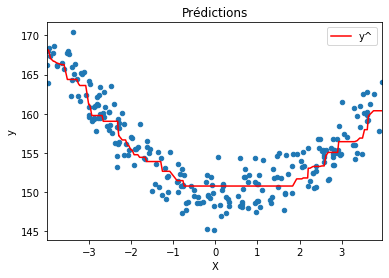

In [5]:
import numpy
ind = numpy.argsort(X_test, axis=0)
y_ = model.predict(X_test)
df = DataFrame({'X': X_test[ind].ravel(), 
                'y': y_test[ind].ravel(),
                'y^': y_[ind].ravel()})
ax = df.plot(x='X', y='y', kind='scatter')
df.plot(x='X', y='y^', kind='line', ax=ax, color="r")
ax.set_title("Prédictions");

Rien d'imprévu jusque là. Essayons autre chose.

In [6]:
model.estimators_.shape

(100, 1)

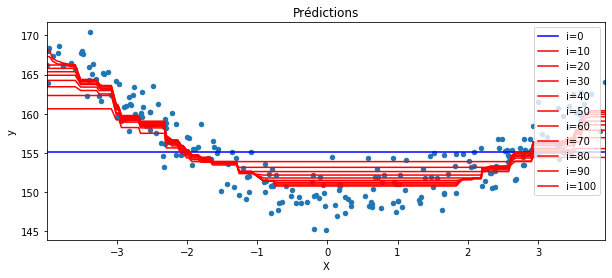

In [7]:
for i in range(0, model.estimators_.shape[0] + 1, 10):
    if i == 0:
        df = DataFrame({'X': X_test[ind].ravel(),
                        'y': y_test[ind].ravel()})
        ax = df.plot(x='X', y='y', kind='scatter', figsize=(10, 4))
        y_ = model.init_.predict(X_test)
        color = 'b'
    else:
        y_ = sum([model.init_.predict(X_test)] + 
                 [model.estimators_[k, 0].predict(X_test) * model.learning_rate
                  for k in range(0, i)])
        color = 'r'
    df = DataFrame({'X': X_test[ind].ravel(),
                    'y^': y_[ind].ravel()})
    df.plot(x='X', y='y^', kind='line', ax=ax, color=color, label='i=%d' % i)
ax.set_title("Prédictions");

## learning rate et itérations

Et si on choisissait un *learning_rate*, plus petit ou plus grand...

In [8]:
model01 = GradientBoostingRegressor(max_depth=1, learning_rate=0.01)
model01.fit(X_train, y_train)
modela = GradientBoostingRegressor(max_depth=1, learning_rate=1.2)
modela.fit(X_train, y_train)
modelb = GradientBoostingRegressor(max_depth=1, learning_rate=1.99)
modelb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.99, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

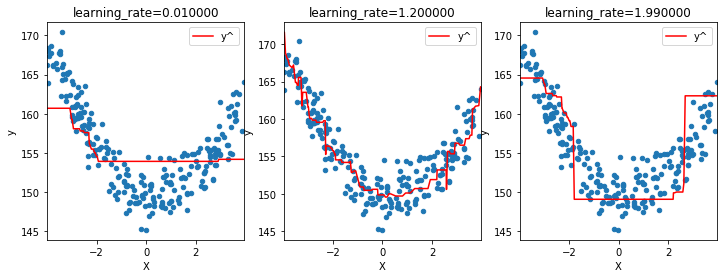

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ind = numpy.argsort(X_test, axis=0)

for i, mod in enumerate([model01, modela, modelb]):
    df = DataFrame({'X': X_test[ind].ravel(), 
                    'y': y_test[ind].ravel(),
                    'y^': mod.predict(X_test)[ind].ravel()})
    df.plot(x='X', y='y', kind='scatter', ax=ax[i])
    df.plot(x='X', y='y^', kind='line', ax=ax[i], color="r")
    ax[i].set_title("learning_rate=%f" % mod.learning_rate);

Une trop faible valeur de *learning_rate* semble retenir le modèle de converger, une grande valeur produit des effets imprévisibles. Pour comprendre pourquoi, il faut détailler l'algorithme...

## L'algorithme

Je reprends ici la page wikipedia. On cherche à construire un modèle qui minimise l'erreur $L(y,F(x)) = \sum_{i=1}^n l(y_i, F(X_i))$. On note $r$ le learning rate.

**Etape 1 :** on cale un premier modèle de régression, ici, simplement une constante, en optimisant $F_0(x) = \arg \min_\gamma \sum_{i=1}^n L(y_i, \gamma)$. $F_0(x)$ est une constante.

On note ensuite $F_m(x) = \gamma_0 \sum_{k=1}^m r \gamma_k h_k(x)$ où $\gamma_0$ est la fonction constante construire lors de la première étape.

**Etape 2 :** on calcule ensuite les erreurs $e_{im} = l(y_i, F_m(x_i))$ et l'opposé du gradient $r_{im} = - \left[ \frac{\partial l(y_i, F_m(x_i)) }{\partial F_m(x_i)} \right]$

**Etape 3 :** on choisit la fonction $h_{m+1}(x)$ de telle sorte qu'elle approxime au mieux les résidus $r_{im}$.

**Etape 4 :** on choisit le coefficient $\gamma_{m+1}$ de telle sorte qu'il minimise l'expression $\min_\gamma \sum_{i=1}^n l\left(y_i, \gamma_0 + \sum_{k=1}^m r \gamma_k h_k(x_i) + \gamma h_{m+1}(x_i)\right)$.

On retourne l'étape 2 autant de fois qu'il y a d'itérations. Lorsque l'erreur est une erreur quadratique $l(y, F(x)) = (y-F(x))^2$, les résidus deviennent $r_{im} = -2 (y_i - F_m(x_i))$. Par conséquent, la fonction $h$ approxime au mieux ce qu'il manque pour atteindre l'objectif. Un learning rate égal à 1 fait que la somme des prédictions de chaque fonction $h_m$ oscille autour de la vraie valeur, une faible valeur donne l'impression d'une fonction qui converge à petits pas, une grande valeur accroît l'amplitude des oscillations au point d'empêcher l'algorithme de converger.

On voit aussi que l'algorithme s'intéresse d'abord aux points où le gradient est le plus fort, donc en principe aux erreurs les plus grandes.

## Régression quantile

Dans ce cas, l'erreur quadratique est remplacée par une erreur en valeur absolue. Les résidus dans ce cas sont égaux à -1 ou 1.

In [10]:
alpha = 0.5
model = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=0.1)
model.fit(X_train, y_train)
model01 = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=0.01)
model01.fit(X_train, y_train)
modela = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=1.2)
modela.fit(X_train, y_train)
modelb = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=1.99)
modelb.fit(X_train, y_train)
modelc = GradientBoostingRegressor(alpha=alpha, loss='quantile', max_depth=1, learning_rate=2.01)
modelc.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.5, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=2.01, loss='quantile',
                          max_depth=1, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

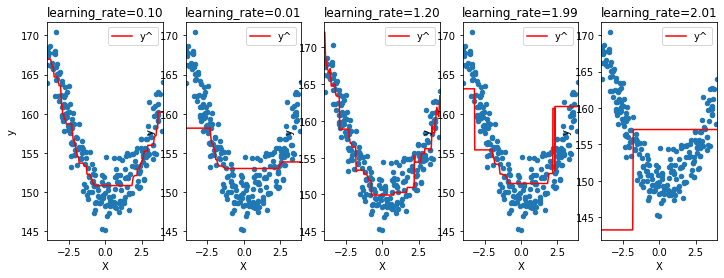

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4))
ind = numpy.argsort(X_test, axis=0)

for i, mod in enumerate([model, model01, modela, modelb, modelc]):
    df = DataFrame({'X': X_test[ind].ravel(), 
                    'y': y_test[ind].ravel(),
                    'y^': mod.predict(X_test)[ind].ravel()})
    df.plot(x='X', y='y', kind='scatter', ax=ax[i])
    df.plot(x='X', y='y^', kind='line', ax=ax[i], color="r")
    ax[i].set_title("learning_rate=%1.2f" % mod.learning_rate);

Concrètement, le paramètre *max_depth=1* correspond à une simple fonction $f(x) = \mathbb{1}_{x > s}$ et le modèle final est une somme pondérée de fonctions indicatrices.

## learning_rate et sur-apprentissage

In [12]:
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def experiment(models, tries=25):
    scores = []
    for _ in tqdm(range(tries)):
        rnd = randn(1000)
        X = random(1000) * 8 - 4
        y = X ** 2 - X + rnd * 2 + 150 # X^2 - X + 150 + epsilon
        X = X.reshape((-1, 1))
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        scs = []
        for model in models:
            model.fit(X_train, y_train)
            sc = model.score(X_test, y_test)
            scs.append(sc)
        scores.append(scs)
    return scores

scores = experiment([
    GradientBoostingRegressor(max_depth=1, n_estimators=100),
    RandomForestRegressor(max_depth=1, n_estimators=100)
])
scores[:3]

100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


[[0.8627767540492498, 0.5868307521542757],
 [0.8485227712984402, 0.5398522837459456],
 [0.8659948863961857, 0.5697787861911169]]

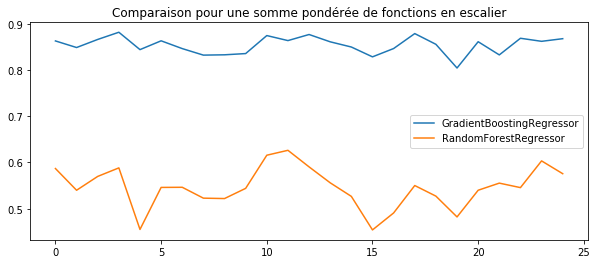

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="GradientBoostingRegressor")
ax.plot([_[1] for _ in scores], label="RandomForestRegressor")
ax.set_title("Comparaison pour une somme pondérée de fonctions en escalier")
ax.legend();

Ce résultat est attendu car la forêt aléatoire est une moyenne de modèle de régression tous appris dans les mêmes conditions alors que le gradient boosting s'intéresse à l'erreur après la somme des premiers régresseurs. Voyons avec des arbres de décision et non plus des fonctions en escaliers.

In [14]:
from sklearn.tree import DecisionTreeRegressor

scores = experiment([
    GradientBoostingRegressor(max_depth=5, n_estimators=100),
    RandomForestRegressor(max_depth=5, n_estimators=100),
    DecisionTreeRegressor(max_depth=5)
])

100%|██████████| 25/25 [00:05<00:00,  4.50it/s]


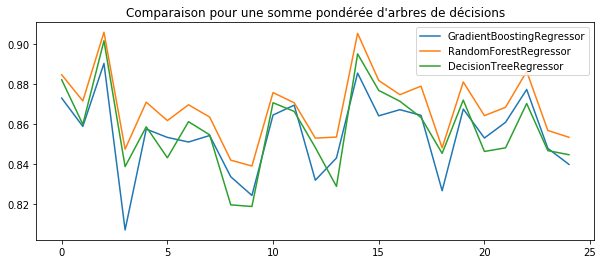

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="GradientBoostingRegressor")
ax.plot([_[1] for _ in scores], label="RandomForestRegressor")
ax.plot([_[2] for _ in scores], label="DecisionTreeRegressor")
ax.set_title("Comparaison pour une somme pondérée d'arbres de décisions")
ax.legend();

Le modèle *GradientBoostingRegressor* est clairement moins bon quand le modèle sous-jacent - l'arbre de décision - est performant. On voit que la forêt aléatoire est meilleure qu'un arbre de décision seul. Cela signifie qu'elle généralise mieux et que l'arbre de décision fait du sur apprentissage. De même, le *GradientBoostingRegressor* est plus exposé au sur-apprentissage.

In [16]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.05),
    GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1),
    GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.2),
])
scores[:2]

100%|██████████| 25/25 [00:08<00:00,  2.93it/s]


[[0.8587921262741204,
  0.8532366248279114,
  0.8470440540146926,
  0.8361958138322483],
 [0.8758796743777308,
  0.873062656259527,
  0.8679772671646249,
  0.8519704165457115]]

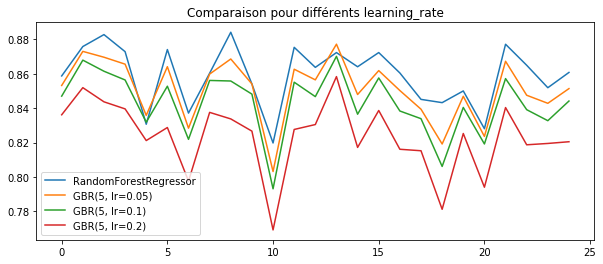

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor")
ax.plot([_[1] for _ in scores], label="GBR(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="GBR(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="GBR(5, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate")
ax.legend();

Diminuer *learning_rate* est clairement une façon d'éviter le sur-apprentissage mais les graphes précédents ont montré qu'il fallait plus d'itérations lorsque le learning rate est petit.

In [18]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    GradientBoostingRegressor(max_depth=1, n_estimators=100, learning_rate=0.05),
    GradientBoostingRegressor(max_depth=1, n_estimators=100, learning_rate=0.1),
    GradientBoostingRegressor(max_depth=1, n_estimators=100, learning_rate=0.2),
])
scores[:2]

100%|██████████| 25/25 [00:06<00:00,  4.08it/s]


[[0.8742985838292042,
  0.8346374120218092,
  0.8743383174325322,
  0.8760899459991678],
 [0.8753377021278533,
  0.8345685583404928,
  0.8756193776916167,
  0.8814738545293597]]

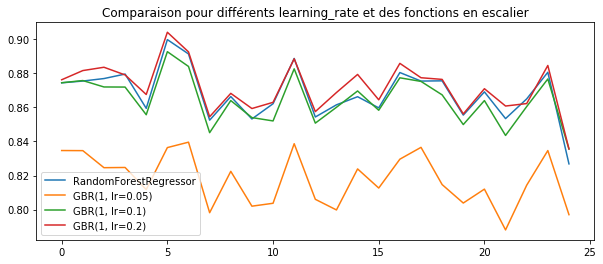

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor")
ax.plot([_[1] for _ in scores], label="GBR(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="GBR(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="GBR(1, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate et des fonctions en escalier")
ax.legend();

Plus le modèle sous-jacent est simple, plus le *learning_rate* peut être élevé car les modèles simples ne font pas de sur-apprentissage.

## Gradient Boosting avec d'autres librairies

Une somme pondérée de régression linéaire reste une regréssion linéaire. Il est impossible de tester ce scénario avec *scikit-learn* puisque seuls les arbres de décisions sont implémentés. Mais il existe d'autres librairies qui implémente le gradient boosting.

### XGBoost

In [20]:
from xgboost import XGBRegressor

In [21]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    XGBRegressor(max_depth=1, n_estimators=100, learning_rate=0.05, objective='reg:squarederror'),
    XGBRegressor(max_depth=1, n_estimators=100, learning_rate=0.1, objective='reg:squarederror'),
    XGBRegressor(max_depth=1, n_estimators=100, learning_rate=0.2, objective='reg:squarederror'),
])
scores[:2]

100%|██████████| 25/25 [00:04<00:00,  5.19it/s]


[[0.8421803598355224,
  0.7757849570019617,
  0.8485143782074356,
  0.8518121839355803],
 [0.8723625224674288,
  0.8103592589532072,
  0.8672831198861998,
  0.8754535147665375]]

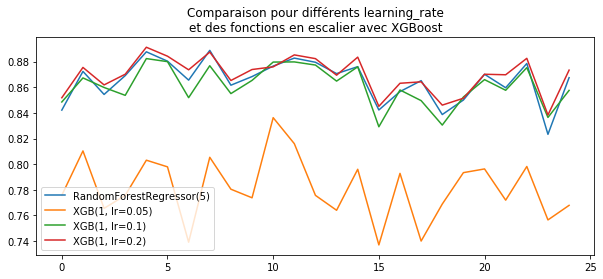

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="XGB(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="XGB(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="XGB(1, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate\net des fonctions en escalier "
             "avec XGBoost")
ax.legend();

Les résultats sont sensiblement les mêmes.

In [23]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.05, objective='reg:squarederror'),
    XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, objective='reg:squarederror'),
    XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.2, objective='reg:squarederror'),
])
scores[:2]

100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


[[0.8583589574468528,
  0.8292516293720251,
  0.857565095231221,
  0.8466933752077339],
 [0.8412325505363488,
  0.8075677718188099,
  0.8406078196676978,
  0.8317079874433916]]

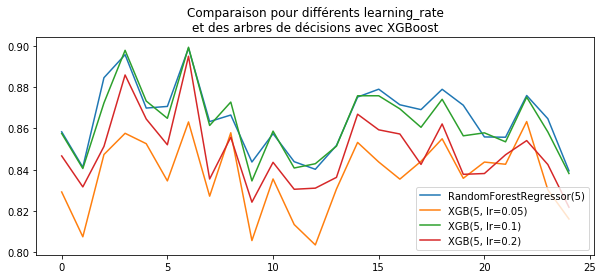

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="XGB(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="XGB(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="XGB(5, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate\net des arbres de décisions "
             "avec XGBoost")
ax.legend();

### LightGbm

In [25]:
from lightgbm import LGBMRegressor

In [26]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    LGBMRegressor(max_depth=1, n_estimators=100, learning_rate=0.05),
    LGBMRegressor(max_depth=1, n_estimators=100, learning_rate=0.1),
    LGBMRegressor(max_depth=1, n_estimators=100, learning_rate=0.2),
])
scores[:2]

100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


[[0.8608651695152849,
  0.8133000215127749,
  0.8624100443819314,
  0.8665899998419848],
 [0.8684612692795836,
  0.8121128225250787,
  0.8652235926266629,
  0.873256512055214]]

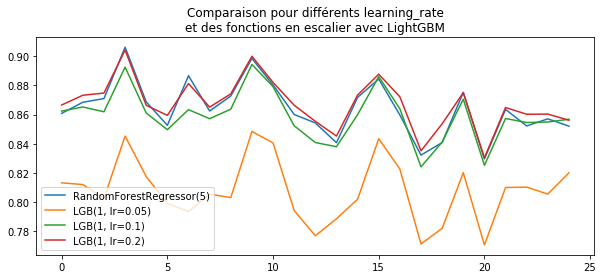

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="LGB(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="LGB(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="LGB(1, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate\net des fonctions en escalier "
             "avec LightGBM")
ax.legend();

In [28]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    LGBMRegressor(max_depth=5, n_estimators=100, learning_rate=0.05),
    LGBMRegressor(max_depth=5, n_estimators=100, learning_rate=0.1),
    LGBMRegressor(max_depth=5, n_estimators=100, learning_rate=0.2),
])
scores[:2]

100%|██████████| 25/25 [00:05<00:00,  4.10it/s]


[[0.8696247178826031,
  0.875040740177272,
  0.8719889926224553,
  0.8699777691793744],
 [0.8546819213067656,
  0.853019881823866,
  0.8509464505871436,
  0.8502151856716562]]

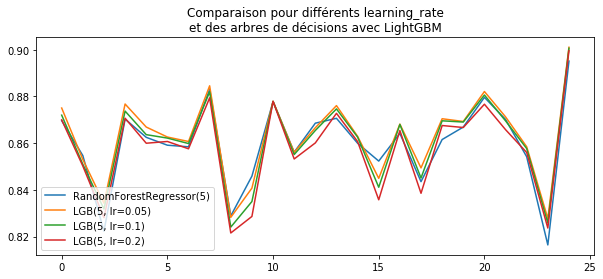

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="LGB(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="LGB(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="LGB(5, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate\net des arbres de décisions "
             "avec LightGBM")
ax.legend();

[LightGBM](https://lightgbm.readthedocs.io/en/latest/) paraît moins sensible au *learning_rate* que [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html).

### CatBoost

[CatBoost](https://catboost.ai/) est une des plus récentes. Elle est sensée être plus efficace pour les catégories ce qui n'est pas le cas ici.

In [30]:
from catboost import CatBoostRegressor

In [31]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    CatBoostRegressor(max_depth=1, n_estimators=100, learning_rate=0.05, verbose=False),
    CatBoostRegressor(max_depth=1, n_estimators=100, learning_rate=0.1, verbose=False),
    CatBoostRegressor(max_depth=1, n_estimators=100, learning_rate=0.2, verbose=False),
])
scores[:2]

100%|██████████| 25/25 [00:16<00:00,  1.56it/s]


[[0.865459256636885,
  0.8199895248567315,
  0.8672747223653066,
  0.8720687082257298],
 [0.8836467160744466,
  0.8166026774215147,
  0.8732026071045378,
  0.8826253111165019]]

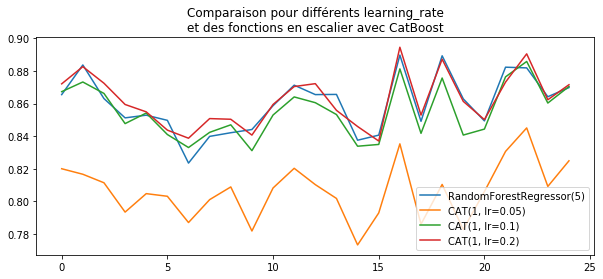

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="CAT(1, lr=0.05)")
ax.plot([_[2] for _ in scores], label="CAT(1, lr=0.1)")
ax.plot([_[3] for _ in scores], label="CAT(1, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate\net des fonctions en escalier "
             "avec CatBoost")
ax.legend();

In [33]:
scores = experiment([
    RandomForestRegressor(max_depth=5, n_estimators=100),
    CatBoostRegressor(max_depth=5, n_estimators=100, learning_rate=0.05, verbose=False),
    CatBoostRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, verbose=False),
    CatBoostRegressor(max_depth=5, n_estimators=100, learning_rate=0.2, verbose=False),
])
scores[:2]

100%|██████████| 25/25 [00:20<00:00,  1.24it/s]


[[0.8566603026744021,
  0.8584896412471671,
  0.8543954535466748,
  0.8523961285985445],
 [0.8522162859870673,
  0.8674232669203256,
  0.8650648775995521,
  0.8578536678710968]]

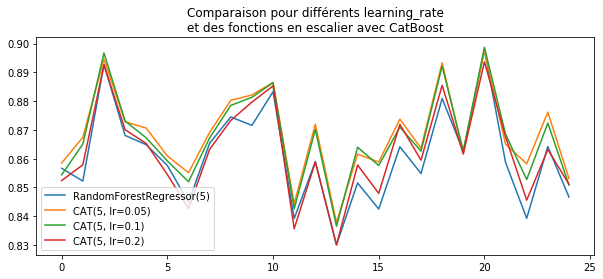

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot([_[0] for _ in scores], label="RandomForestRegressor(5)")
ax.plot([_[1] for _ in scores], label="CAT(5, lr=0.05)")
ax.plot([_[2] for _ in scores], label="CAT(5, lr=0.1)")
ax.plot([_[3] for _ in scores], label="CAT(5, lr=0.2)")
ax.set_title("Comparaison pour différents learning_rate\net des fonctions en escalier "
             "avec CatBoost")
ax.legend();